In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
import gc
import sys
sys.path.insert(0,'/home/dan/Desktop/kaggle/kaggle-ieee-cis-fraud-detection/src/')

import pandas as pd
import numpy as np

import lightgbm as lgb
import matplotlib.pyplot as pyplot


# from preprocess import preprocess
# from train import train_eval_model

from load import BaseDataLoader
from packager import Packager
from feature_engineer import FeatureEngineer
from cross_val_labo import CrossValLabo
from settings import DATA_DIR

In [13]:
data = BaseDataLoader(DATA_DIR).files
trs_train = data['train_transaction']
trs_test = data['test_transaction']
del data
gc.collect()

Loaded tables' types are not converted


3026

In [14]:
train_mask, val_mask = Packager.get_train_val_masks(trs_train)

In [15]:
train = trs_train[train_mask]
val = trs_train[val_mask]
feat_cols, label_col = Packager.split_feat_label(train)
X_train = train[feat_cols]
Y_train = train[label_col]
X_val = val[feat_cols]
Y_val = val[label_col]
del train
del val
gc.collect()

0

In [ ]:
skip = ['trs_amt_scale', 'trs_amt_diff', 'trs_amt_round', 'trs_card_type_dum'] #, 'trs_card_type_dum' 'trs_amt_sin', 
exclude = ['trs_amt_diff'] #['trs_amt_scale', 'trs_amt_round']
fi = FeatureEngineer(skip, exclude)
X_train_prepro = fi.transform(X_train, 'TransactionID', 'train')
X_val_prepro = fi.transform(X_val, 'TransactionID', 'val')

step 0: trs_amt_sin


In [57]:
lgb_params = {
                'objective':'regression',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':8,
                'learning_rate':0.01,
                'num_leaves': 2**4,
                'max_depth':5,
                'tree_learner':'serial',
                'colsample_bytree': 0.80,
                'subsample_freq':1,
                'subsample':1,
                'n_estimators':2**10,
                'max_bin':255,
                'verbose':-1,
                'seed': 1337,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            }
model = lgb.LGBMClassifier(**lgb_params)

lgb_params_crossval = {
                'learning_rate':[0.01],
                'max_bin':[255],
                'reg_alpha':[0.3],
                'reg_lamdba':[0.243]
            }



In [58]:
best_parameters_val, score_val, score_train, model = CrossValLabo.optimize_hparams(model, lgb_params_crossval, X_train_prepro, Y_train, X_val_prepro, Y_val)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.01, max_bin=255, reg_alpha=0.3, reg_lamdba=0.243 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_bin=255, reg_alpha=0.3, reg_lamdba=0.243, total=   7.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


In [59]:
print(best_parameters_val)
print(score_val)
print(score_train)

{'learning_rate': 0.01, 'max_bin': 255, 'reg_alpha': 0.3, 'reg_lamdba': 0.243}
0.6975390944479354
0.7355700988307257


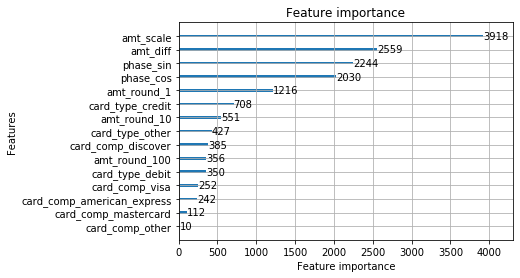

In [60]:
lgb.plot_importance(model)